<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Augmentation**: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


## Download flowers dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(name='tf_flowers',
                                                  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  as_supervised=True,
                                                  with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


flowers dataset has five classes 

In [ ]:
num_classes = metadata.features['label'].num_classes
print('Number of classes of flowers', num_classes)

Number of classes of flowers 5


In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))

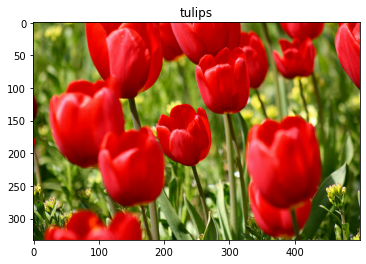

In [ ]:
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

## Use Keras preprocessing layers

**Resizing and rescaling**

You can use preprocessing layers to resize your images to a consistent shape, and to rescale pixel values.

In [ ]:
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE),
                                          tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255.0)
])

Note: the rescaling layer above standardizes pixel values to [0,1]. If instead you wanted [-1,1], you would write Rescaling(1./127.5, offset=-1).

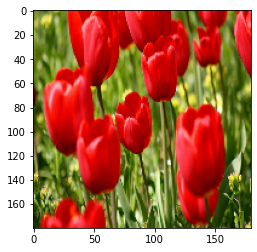

In [ ]:
result = resize_and_rescale(image)
plt.imshow(result);

In [ ]:
# You can verify the pixels are in [0-1]
print('Min value',result.numpy().min())
print('Max value',result.numpy().max())

Min value 0.0
Max value 1.0


## Data augmentation
You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2)
])

In [ ]:
# Add the image to a batch
batch_image = tf.expand_dims(image, axis=0)

print('Shape of image', batch_image.shape)

Shape of image (1, 333, 500, 3)


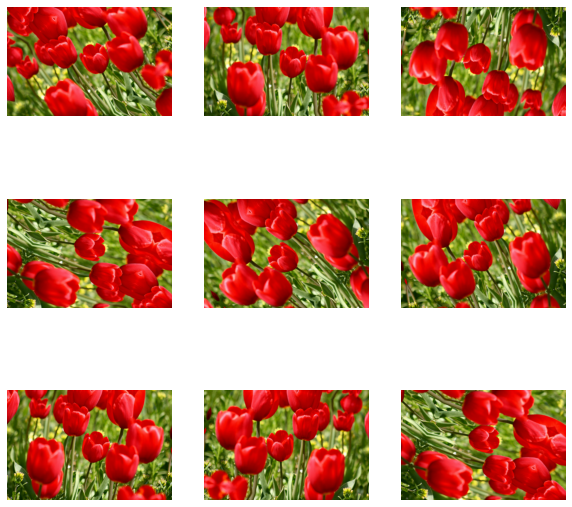

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_img = data_augmentation(batch_image)
  plt.subplot(3,3,i+1)
  plt.imshow(augmented_img[0])
  plt.axis('off')

In [ ]:
def display_augmented_images():
  plt.figure(figsize=(20,15))
  for i in range(6):
    augmented_img = data_augmentation(batch_image)
    plt.subplot(1,6,i+1)
    plt.imshow(augmented_img[0])
    plt.axis('off')

**Contrast**

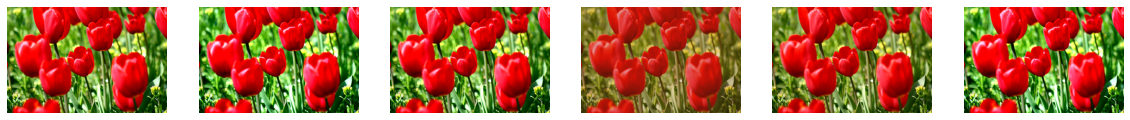

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.7)
])

display_augmented_images()

**Zoom out**

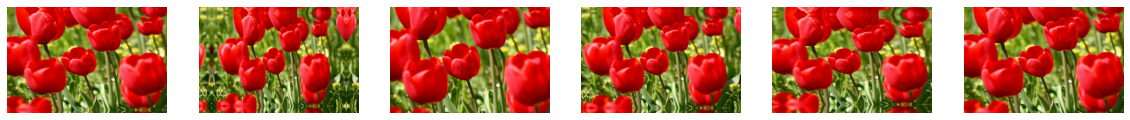

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.3)
])

display_augmented_images()

**Zoom in**

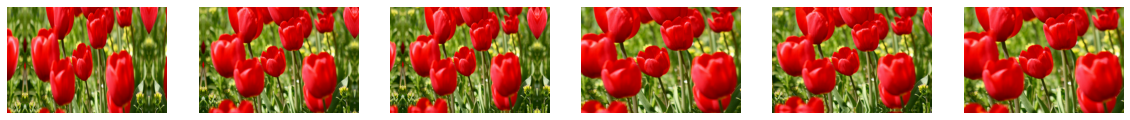

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=-0.2, width_factor=-0.3)
])

display_augmented_images()

**Random crop**

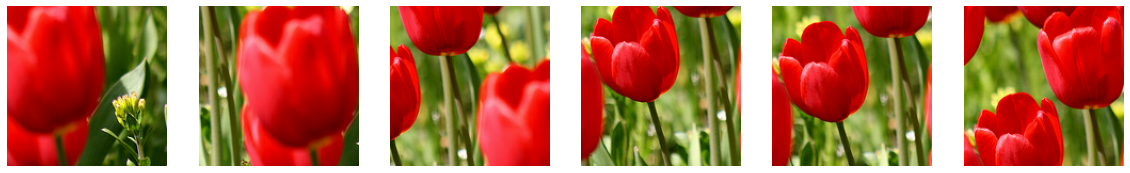

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomCrop(height=150, width=150)
])

display_augmented_images()

**Two options to use the preprocessing layers**

There are two ways you can use these preprocessing layers, with important tradeoffs.

Option 1: Make the preprocessing layers part of your model

<br>
model = tf.keras.Sequential([<br>
  resize_and_rescale,<br>
  data_augmentation,<br>
  layers.Conv2D(16, 3, padding='same', activation='relu'),<br>
  layers.MaxPooling2D(),<br>
  `# Rest of your model`<br>
])<br>
<br>

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

**Note: Data augmentation is inactive at test time so input images will only be augmented during calls to model.fit (not model.evaluate or model.predict)**.


Option 2: Apply the preprocessing layers to your dataset

<br>
aug_ds = train_ds.map(<br>
  lambda x, y: (resize_and_rescale(x, training=True), y))<br>
<br>

* With this approach, you use Dataset.map to create a dataset that yields batches of augmented images.

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`.

In this case the prepreprocessing layers will not be exported with the model when you call `model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

**Apply the preprocessing layers to the datasets**

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. 

**Note: data augmentation should only be applied to the training set.**

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.Resizing(height=IMG_SIZE, width=IMG_SIZE),
                                          tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255.0)
])

data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2)
])

In [ ]:
BATCH_SIZE = 32

def prepare(ds, shuffle=False, augment=False):

  # apply Resize and Rescale to all dataset
  ds = ds.map(lambda img,label: (resize_and_rescale(img), label) , num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)
  
  # batch all dataset
  ds = ds.batch(BATCH_SIZE)

  # use data-augmentation only on training
  if augment:
    ds = ds.map(lambda img,label:(data_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)
  
  # use  buffered prefecting on all datasets
  return ds.prefetch(tf.data.AUTOTUNE)

  

In [ ]:
train_data =  prepare(train_ds, shuffle=True, augment=True)
val_data = prepare(val_ds)
test_data = prepare(test_ds)

## Training a model 

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [ ]:
history = model.fit(x=train_data, validation_data=val_data, epochs=100, callbacks=[early_stopping])

Epoch 1/100
92/92 [==============================] - 92s 976ms/step - loss: 1.3578 - accuracy: 0.3958 - val_loss: 1.2758 - val_accuracy: 0.4196
Epoch 2/100
92/92 [==============================] - 88s 952ms/step - loss: 1.1514 - accuracy: 0.5255 - val_loss: 1.0605 - val_accuracy: 0.6049
Epoch 3/100
92/92 [==============================] - 88s 950ms/step - loss: 1.0332 - accuracy: 0.5875 - val_loss: 0.9673 - val_accuracy: 0.6104
Epoch 4/100
92/92 [==============================] - 88s 948ms/step - loss: 0.9637 - accuracy: 0.6131 - val_loss: 0.9806 - val_accuracy: 0.6076


In [ ]:
loss, accuracy = model.evaluate(test_data)
print('Loss', loss)
print('Model Accuracy', accuracy)

12/12 [==============================] - 3s 258ms/step - loss: 0.9331 - accuracy: 0.6131
Loss 0.933140218257904
Model Accuracy 0.6130790114402771


## Custom data augmentation
You can also create custom data augmenation layers. This tutorial shows two ways of doing so. First, you will create a `layers.Lambda` layer. This is a good way to write concise code. Next, you will write a new layer via subclassing, which gives you more control. Both layers will randomly invert the colors in an image, according to some probability.

The Lambda layer exists so that arbitrary expressions can be used as a Layer when constructing Sequential and Functional API models. Lambda layers are best suited for simple operations or quick experimentation.

The main reason to subclass `tf.keras.layers.Layer` instead of using a `Lambda layer` is saving and inspecting a Model. Lambda layers are saved by serializing the Python bytecode, which is fundamentally non-portable. They should only be loaded in the same environment where they were saved. Subclassed layers can be saved in a more portable way by overriding their `get_config` method. Models that rely on subclassed Layers are also often easier to visualize and reason about.

In general, Lambda layers can be convenient for simple stateless computation, but anything more complex should use a subclass Layer instead.

In [ ]:
def random_invert_img(x, prob=0.5):
  if tf.random.uniform([])<prob:
    x = (255-x)
  return x

In [ ]:
def random_invert(factor=0.5):
  return tf.keras.layers.Lambda(lambda img: random_invert_img(img, factor))

In [ ]:
invert = random_invert()

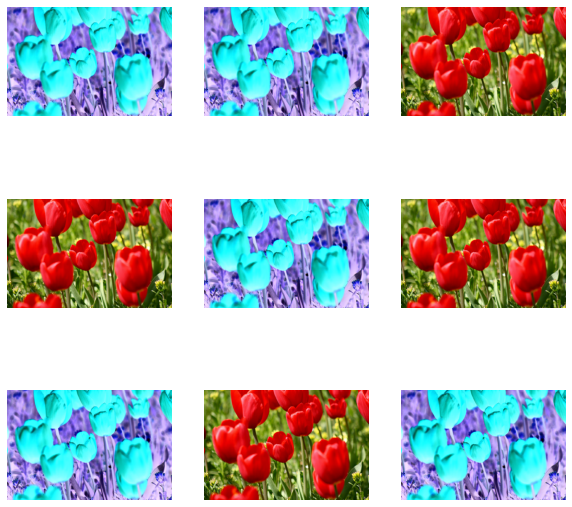

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  augmented_img = invert(image)
  plt.imshow(augmented_img)
  plt.axis(False)

Next, implement a custom layer by subclassing.

In [ ]:
class Random_invert(tf.keras.layers.Layer):
  def __init__(self, factor=0.05, **kwargs):
    super(Random_invert, self).__init__(**kwargs)
    self.factor = factor
  
  def call(self, x):
    return random_invert_img(x, self.factor)

In [ ]:
invert = Random_invert()

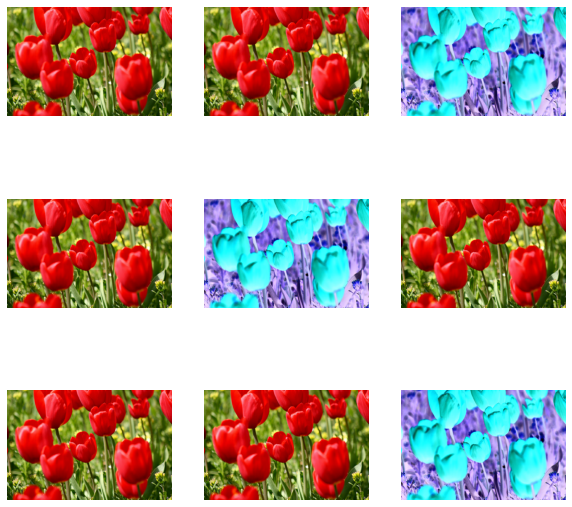

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  augmented_img = invert(image)
  plt.imshow(augmented_img)
  plt.axis(False)

## Using tf.image
The above layers.preprocessing utilities are convenient. For finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`.

Let's create the following function to visualize and compare the original and augmented images side-by-side.

In [ ]:
def visualize(original, augmented):
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ax[0].imshow(original)
  ax[0].set_title('Original image')
  ax[0].axis('off')
  ax[1].imshow(augmented)
  ax[1].set_title('Augmented image')
  ax[1].axis('off')


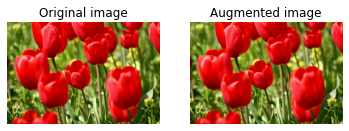

In [ ]:
visualize(image, image)

**Data augmentation**

**Flipping the image**

Flip the image either vertically or horizontally.

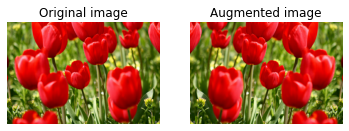

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

**Data augmentation**

**Gray scale image**

Shape of gray-scaled image  (333, 500, 1)


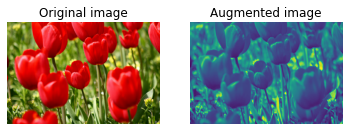

In [ ]:
gray_scaled = tf.image.rgb_to_grayscale(image)
print('Shape of gray-scaled image ',gray_scaled.shape)
# Removes dimensions of size 1 from the shape of a tensor.
visualize(image, tf.squeeze(gray_scaled))

**Data augmentation**

**Saturate the image**

Saturate an image by providing a saturation factor.

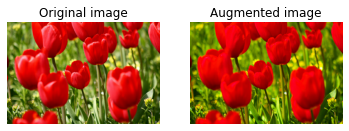

In [ ]:
saturated_img = tf.image.adjust_saturation(image, saturation_factor=3)
visualize(image, saturated_img)

**Data augmentation**

**Change image brightness**

Change the brightness of image by providing a brightness factor.

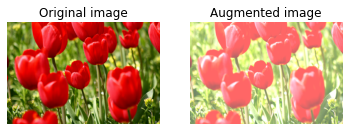

In [ ]:
bright_img = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright_img)

**Data augmentation**

**Center crop the image**

Crop the image from center up to the image part you desire.

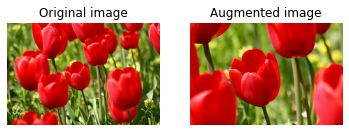

In [ ]:
center_cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, center_cropped)

**Data augmentation**

**Rotate the image**

Rotate an image by 90 degrees.

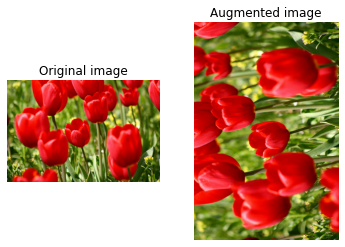

In [ ]:
rotated_img = tf.image.rot90(image)
visualize(image, rotated_img)

Applying random transformations to the images can further help generalize and expand the dataset. Current tf.image API provides 8 such random image operations (ops):

<br>
`tf.image.stateless_random_brightness`<br>
`tf.image.stateless_random_contrast`<br>
`tf.image.stateless_random_crop`<br>
`tf.image.stateless_random_flip_left_right`<br>
`tf.image.stateless_random_flip_up_down`<br>
`tf.image.stateless_random_hue`<br>
`tf.image.stateless_random_jpeg_quality`<br>
`tf.image.stateless_random_saturation`<br>
<br>

These random image ops are purely functional: the ouput only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a seed value be input each step. Given the same seed, they return the same results independent of how many times they are called.

**Note: seed is a Tensor of shape (2,) whose values are any integers.**


**Randomly change image brightness**

Randomly change the brightness of image by providing a brightness factor and seed. The brightness factor is chosen randomly in the range [-max_delta, max_delta) and is associated with the given seed.

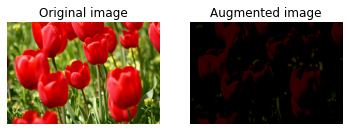

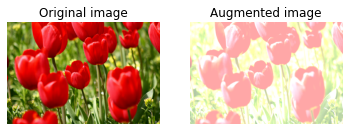

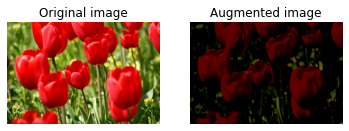

In [ ]:
for i in range(3):
  seed = (i,i+1)
  augmented_img = tf.image.stateless_random_brightness(image, max_delta=0.95, seed=seed)
  visualize(image, augmented_img)


**Randomly change image contrast**

Randomly change the contrast of image by providing a contrast range and seed. The contrast range is chosen randomly in the interval [lower, upper] and is associated with the given seed.

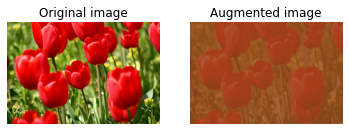

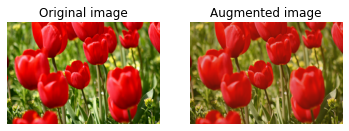

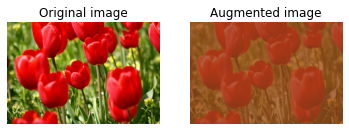

In [ ]:
for i in range(3):
  seed = (i,i+1)
  augmented_img = tf.image.stateless_random_contrast(image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, augmented_img)

**Randomly crop an image**

Randomly crop image by providing target size and seed. The portion that gets cropped out of image is at a randomly chosen offet and is associated with the given seed.

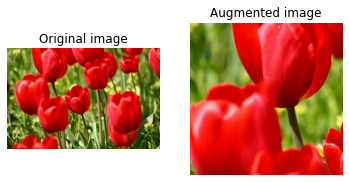

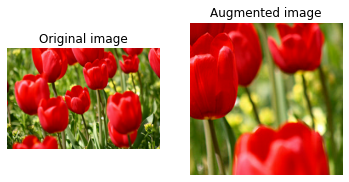

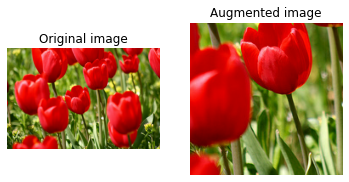

In [ ]:
for i in range(3):
  seed = (i,i+1)
  augmented_img = tf.image.stateless_random_crop(image, size=[180,180,3], seed=seed)
  visualize(image, augmented_img)

## Apply augmentation to a dataset

Let's define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:


In [3]:
IMG_SIZE = 180

def resize_and_rescale(img, label):
  img = tf.cast(img, dtype=tf.float32)
  img = tf.image.resize(img, size=[IMG_SIZE, IMG_SIZE])
  img = img / 255.0
  return img, label

Let's also define augment function that can apply the random transformations to the images. 

In [29]:
def augment(img_label, seed):
  img, label = img_label
  img, label = resize_and_rescale(img, label)
  img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE+6, IMG_SIZE+6)
  # make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0,:]
  # Random crop back to the original size
  img = tf.image.stateless_random_crop(img, size=[IMG_SIZE,IMG_SIZE,3], seed=new_seed)
  # random brightness
  img = tf.image.stateless_random_brightness(img, max_delta=0.5, seed=new_seed)
  img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=1)
  return img, label

Option 1: Using `tf.data.experimental.Counter()`

Create a `tf.data.experimental.Counter()` object (let's call it counter) and zip the dataset with (counter, counter). This will ensure that each image in the dataset gets associated with a unique value (of shape (2,)) based on counter which later can get passed into the augment function as the seed value for random transformations.

In [45]:
counter = tf.data.experimental.Counter()
train_data = tf.data.Dataset.zip((train_ds, (counter, counter)))

Map the augment function to the training dataset

Map the Resize&Rescale function to validation, testing datasets.

In [48]:
train_data = (train_data
              .shuffle(1000)
              .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

In [49]:
val_data = (val_ds
              .map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

In [50]:
test_data = (test_ds
              .map(resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

Option 2: Using `tf.random.Generator`

Create a `tf.random.Generator` object with an intial seed value. Calling make_seeds function on the same generator object returns a new, unique seed value always. 

Define a wrapper function that 
* (1) calls make_seeds function on the same generator object 
* (2) passes the newly generated seed value into the augment function for random transformations.

Note: `tf.random.Generator` objects store RNG state in a `tf.Variable`, which means it can be saved as a checkpoint or in a SavedModel.

In [51]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [57]:
# make seed and pass the seed to augment-fn
def utiltiy(img, label):
  seeds = rng.make_seeds(2)
  # pass the seed
  return augment((img, label), seeds[0])

In [59]:
train_data = (train_ds
              .shuffle(1000)
              .map(utiltiy, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

In [60]:
val_data = (val_ds
              .map(utiltiy, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))

In [61]:
test_data = (test_ds
              .map(utiltiy, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE))